### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

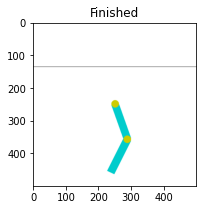

In [2]:
# 导入gym库
import gym

# 创建环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('Acrobot-v1', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(20):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

### A2C

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# Actor-Critic网络
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        
        # 使用全连接层构建一个简单的神经网络，共享部分网络层
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        
        # 分别定义actor和critic对应的全连接层
        self.actor = nn.Linear(128, output_dim)
        self.critic = nn.Linear(128, 1)

    # 定义前向传播
    def forward(self, x):
        # 使用ReLU函数对前两个全连接层的输出进行变换
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # actor网络输出使用softmax函数，得到概率分布
        actor_output = F.softmax(self.actor(x), dim = 1)
        # critic网络输出，得到给定状态的价值估计
        critic_output = self.critic(x)
        
        # 依次返回对应结果
        return actor_output, critic_output

In [4]:
# A2C算法
class A2C:
    # 构造函数，参数包含环境，学习率，折扣因子
    def __init__(self, env, learning_rate=0.002, gamma=0.99):
        self.env = env
        self.gamma = gamma

        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 创建ActorCritic网络，并将模型移动到指定设备上
        self.actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n).to(self.device)

        # 定义Adam优化器
        self.optimizer = torch.optim.Adam(self.actor_critic.parameters(), lr=learning_rate)

    # 使用模型生成动作概率分布并采样
    def choose_action(self, state):
        # 将状态转换为tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        with torch.no_grad():
            action_prob, _ = self.actor_critic(state)
        
        # 生成分布后采样返回动作
        c = torch.distributions.Categorical(action_prob)
        action = c.sample()
        return action.item()
    
    # 模型更新
    def update(self, buffer):
        # 取出数据，并将其转换为numpy数组
        # 然后进一步转换为tensor，并将数据转移到指定计算资源设备上
        states, actions, rewards, next_states, dones = zip(*buffer)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)
        
        # 计算TD目标及误差
        action_prob, state_value = self.actor_critic(states)
        _, next_state_value = self.actor_critic(next_states)
        td_target = rewards + (1 - dones) * self.gamma * next_state_value
        td_delta = td_target - state_value
        
        # 计算动作概率的对数
        log_prob = torch.log(action_prob.gather(1, actions))

        # 计算actor和critic的loss
        actor_loss = -(log_prob * td_delta.detach()).mean()
        critic_loss = F.mse_loss(state_value, td_target).mean()
        # 总loss设为actor_loss和critic_loss的加权和
        loss = actor_loss + critic_loss * 0.5

        # 梯度清零、反向传播、更新参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
# 定义超参数
max_episodes = 300 # 训练episode数

# 创建A2C对象
agent = A2C(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0
    # 记录每个episode的信息
    buffer = []

    # 循环进行每一步操作
    while 1:
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 将这个五元组加到buffer中
        buffer.append((state, action, reward, next_state, done))
        # 累计奖励
        episode_reward += reward
        
        # 更新当前状态
        state = next_state

        if done:
            break
    
    # 更新策略
    agent.update(buffer)
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)
    
    # 打印中间值
    if episode % (max_episodes // 10) == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: -500.0                      
Episode 30: -500.0                              
Episode 60: -496.0                              
Episode 90: -149.0                              
Episode 120: -170.0                              
Episode 150: -114.0                              
Episode 180: -115.0                              
Episode 210: -95.0                               
Episode 240: -73.0                               
Episode 270: -76.0                               
100%|██████████| 300/300 [00:22<00:00, 13.34it/s]


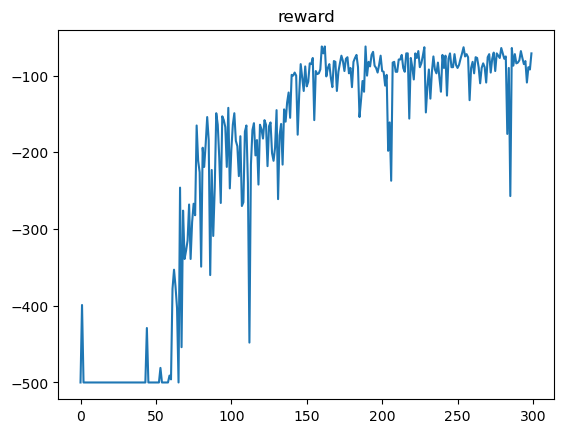

In [6]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

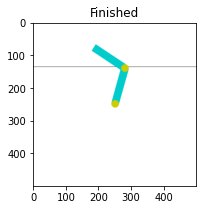

In [7]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 开始游戏
for i in range(500):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 找到当前状态下的最优动作
    action = agent.choose_action(observation)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()